## Kelley hu4d5-5 VL-E55Y charging step error analysis

In this notebook we will use a random forest model to find the most energetically influential degrees of freedom for the VL-E55Y charging step TI production run. Next, we will compare the sampling of these DOF during TI production to a free energy profile derived from end state GaMD sampling. We will attempt to  correct any inaccurate sampling in the TI data and find the estimated ddG before and after the correction. 

In [1]:
import os
os.chdir("..")
from common_functions import *

### Ingesting original TI lambda production data

In [2]:
os.chdir("./TI_data/VL-E55Y")
geom_dvdls_crg = pd.read_csv("E55Y_crg_bound.csv")
geom_dvdls_crg_ub = pd.read_csv("E55Y_crg_unbound.csv")
geom_dvdls_vdw = pd.read_csv("E55Y_vdw_bound.csv")
dvdls_ub_vdw = pd.read_csv("E55Y_vdw_unbound.csv")


### Original TI ddG estimate:

In [3]:
dG_bd_crg = geom_dvdls_crg.groupby("Lambda").mean()["weight_dvdl"].sum()
dG_ubd_crg = geom_dvdls_crg_ub.groupby("Lambda").mean()["weight_dvdl"].sum()
ddG_crg = dG_bd_crg - dG_ubd_crg

dG_bd_vdw = geom_dvdls_vdw.groupby("Lambda").mean()["weight_dvdl"].sum()
dG_ubd_vdw = dvdls_ub_vdw.groupby("Lambda").mean()["weight_dvdl"].sum()
ddG_vdw = dG_bd_vdw - dG_ubd_vdw

empirical_value = -0.18

print("Original ddG (crg step): ")
print(f"{round(ddG_crg, 4)} kcal/mol")

print("Original ddG (vdw step): ")
print(f"{round(ddG_vdw, 4)} kcal/mol")

print("Original total ddG: ")
print(f"{round(ddG_crg + ddG_vdw, 4)} kcal/mol")

print()
print("Empirical value: ")
print(f"{empirical_value} kcal/mol")

orig_error = abs((ddG_crg + ddG_vdw) - empirical_value)

print("Original ddG error: ")
print(f"{round(orig_error, 4)} kcal/mol")

Original ddG (crg step): 
-1.9403 kcal/mol
Original ddG (vdw step): 
0.5016 kcal/mol
Original total ddG: 
-1.4387 kcal/mol

Empirical value: 
-0.18 kcal/mol
Original ddG error: 
1.2587 kcal/mol


### Charging step RF model

#### Splitting data into independent/dependent variables for random forest model

See our methods/supplemental methods section for our process to choose the input features.

In [4]:
X_5A = geom_dvdls_crg.drop([
    "#Frame", "weight_dvdl", "dvdl", "Run", "Lambda", "Y404_chi2", "F239_chi1", "D243_chi2", "e410_s411", "e410_g412"
], axis=1)
Y = geom_dvdls_crg["weight_dvdl"]

X_scl = pd.DataFrame(StandardScaler().fit_transform(X_5A))
X_scl.columns = X_5A.columns


#### Checking to see if there is any cross-correlations within the dataset

In [5]:
absCorr = abs(X_scl.corr())
for i in absCorr.columns:
    for j in absCorr.index:
        cor = absCorr.loc[i, j]
        if abs(cor) > 0.5 and i != j:
            print(i, j)
            print(cor)
            

#### Using random forest model to identify the most influential degrees of freedom

We run our model 25 times, then sort the results by the mean of feature importance across the 25 iterations. 

In [29]:
rfeDefault = RFE(estimator=DecisionTreeRegressor(max_depth=5, random_state=42), n_features_to_select=0.75, step=0.05)
rfDefault = RandomForestRegressor(
    max_depth=10, n_estimators=200, oob_score=True, max_features=0.6, min_samples_leaf = 7, min_samples_split=14, random_state=42
)

pipelineDefault_rf = Pipeline([
    ('feature_scaling', StandardScaler()),
    # ('pre_select', kbest),
    ('feature_selection', rfeDefault),
    ('regression_model', rfDefault)
])


imps = benchmark_model(pipelineDefault_rf, X_scl, Y, geom_dvdls_crg["Lambda"])
imps[["Mean", "Median"]].sort_values(by="Mean", ascending=False)[:15]

Avg. training r2: 
0.7003
Training r2 std dev: 
0.0021
Avg. test r2: 
0.5906
Testing r2 std dev: 
0.0045


,Mean,Median
e410_s411bb,0.267894,0.267219
E410_chi1,0.117624,0.116991
F408_chi2,0.098884,0.109071
F239_chi2,0.091183,0.091129
E410_chi3,0.069909,0.067987
Y404_chi1,0.059172,0.071546
K400_chi1,0.050615,0.050510
E410_chi2,0.040682,0.040504
L409_chi2,0.040283,0.008094
D243_chi1,0.039467,0.039493


### Comparing TI production sampling of VL-E55:VL-S56 distance with GaMD 1-D pmf (bound state)

Based on the RF model indicating that the distance between VL-E55 and VL-S56 is the most important feature, we will compare the GaMD pmf profile of this distance to what was sampled during TI.

If we check the GaMD profile, the main peak appears to be from 2.7 A - 4 A, suggesting a hydrogen bond. A few frames during TI do not contain this hydrogen bond. 

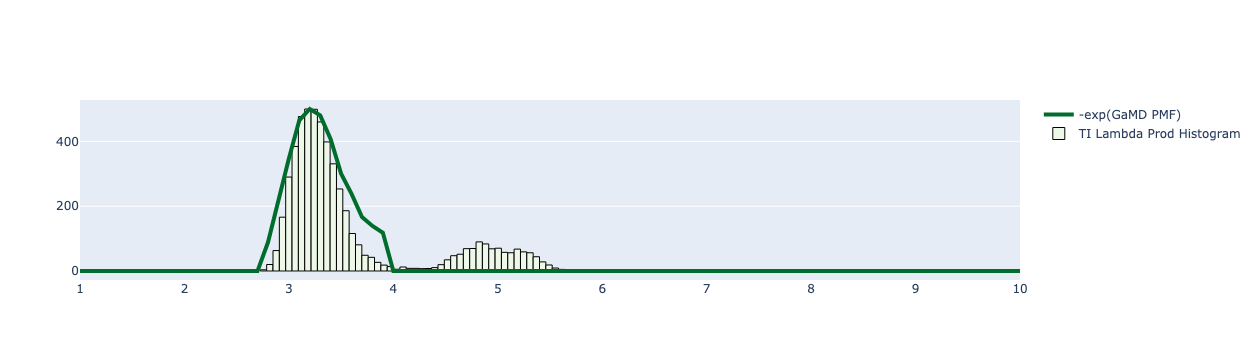

In [6]:
os.chdir("../../gamd_pmfs/VL-E55Y")
e410_s411 = get_pmf(
    "pmf-c2-E410_S411_conv_300ns.dat.xvg"
)

fig = plot_pmf_TI_1D_fig(e410_s411, geom_dvdls_crg, "e410_s411bb", 500, 50).update_xaxes(range=[1, 10]).show(
    renderer="jupyterlab")

### Recomputing charging step bound state dG

This time, we will filter out all frames in which the VL-E55:VL-S56 distance exceeds 4 Angstroms.

In [7]:
pmf_state = geom_dvdls_crg[(geom_dvdls_crg["e410_s411bb"] > 2.7) & (geom_dvdls_crg["e410_s411bb"] < 4)]
print(pmf_state.groupby("Lambda").count()["weight_dvdl"])

dG_corr = pmf_state.groupby("Lambda").mean().sum()["weight_dvdl"]


Lambda
1     991
2     970
3     996
4     984
5     992
6     985
7     893
8     676
9     670
10    504
11    386
12    590
Name: weight_dvdl, dtype: int64


### Comparing TI production sampling of VL-E55:VL-S56 distance with GaMD 1-D pmf (unbound state)

We will repeat what was done above for the unbound state. Again, a few frames exceed the 3.9 A distance - we will filter these and re-compute the unbound state dG.

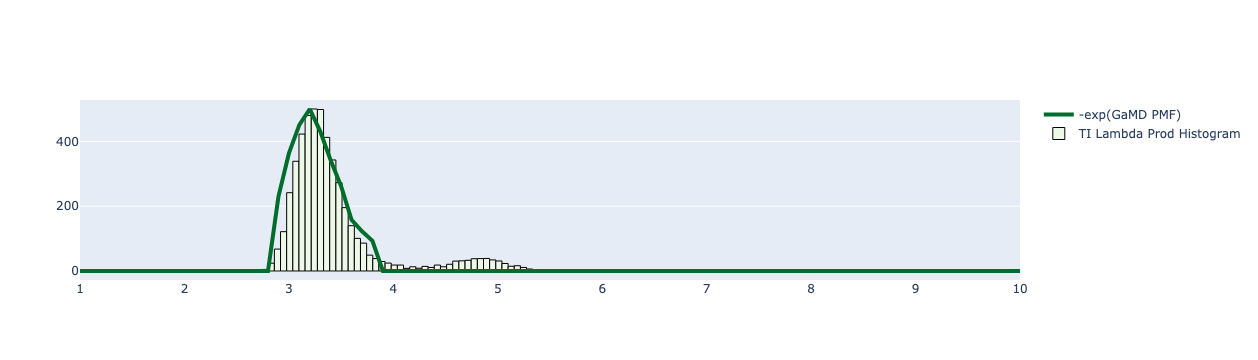

In [12]:
os.chdir("../../gamd_pmfs/VL-E55Y")
e55_s56 = get_pmf(
    "pmf-c2-E55_S56_conv_300ns.dat.xvg"
)

fig = plot_pmf_TI_1D_fig(e55_s56, geom_dvdls_crg_ub, "e275_s276bb", 500, 50).update_xaxes(range=[1, 10]).show(
    renderer="jupyterlab")

### Recomputing charging step bound state dG

We will filter out all frames in which the VL-E55:VL-S56 distance exceeds 3.9 Angstroms.

In [15]:
pmf_state_ub = geom_dvdls_crg_ub[(geom_dvdls_crg_ub["e275_s276bb"] > 2.8) & (geom_dvdls_crg_ub["e275_s276bb"] < 3.9)]
print(pmf_state_ub.groupby("Lambda").count()["weight_dvdl"])

dG_corrUb = pmf_state_ub.groupby("Lambda").mean().sum()["weight_dvdl"]

Lambda
1     983
2     984
3     985
4     986
5     982
6     966
7     866
8     856
9     800
10    707
11    763
12    773
Name: weight_dvdl, dtype: int64


### Results based on 1-D correction 

The vdw results had no change because model R^2 was too low (see the VL-E55Yvdw_example notebook).

In [16]:
print("Corrected ddG, crg step")
print((dG_corr - dG_corrUb) )

print("Corrected ddG, total")
print((dG_corr - dG_corrUb) + (dG_bd_vdw - dG_ubd_vdw))

print("Updated error: ")
print(f"{round(abs(((dG_corr - dG_corrUb) + (dG_bd_vdw - dG_ubd_vdw)) - empirical_value), 4)} kcal/mol")

Corrected ddG, crg step
-1.313556376442449
Corrected ddG, total
-0.8119457941404562
Updated error: 
0.6319 kcal/mol
